
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Overall
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great job. Keep up the effort.</span></div></div>

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.


**1.3** Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.

Plot two histograms ofyour best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.

Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.


**1.4** Using your top gene from the previous part (call it  `best_predictor`), create a classification model by manually eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.

<hr> <hr>

<hr>
### Solutions

**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('hw4_enhance.csv', index_col=0)
X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))

(752, 7130)
(601, 7129) (151, 7129) (601,) (151,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


In [5]:
y_train.head()

486    1.0
604    1.0
341    1.0
117    1.0
516    1.0
Name: Cancer_type, dtype: float64

**1.1 Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.**


In [6]:
#your code here
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,-115.860969,-160.846155,26.545301,209.733439,-248.992903,-405.422569,-24.135140,-188.491329,74.777098,97.436777,...,161.766492,707.377318,4.198787,421.466477,-50.023954,819.053113,329.803212,8.803791,507.250039,-24.377549
std,170.571929,188.676919,207.781982,202.987246,207.328054,261.112412,535.143398,163.077167,174.693115,358.897719,...,165.152970,526.644408,152.401188,589.914084,106.864078,814.898058,367.788891,85.397644,939.394188,71.102874
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-501.285884,-1010.430536,-447.077819,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-222.586579,-270.502055,-95.000000,85.327810,-379.048622,-567.547758,-338.435164,-302.872287,-20.739507,-117.000000,...,67.861184,361.596510,-88.660905,88.409441,-105.000000,270.198265,90.825501,-40.391630,-50.785999,-73.000000
50%,-105.139096,-145.829450,21.183690,207.291048,-231.007621,-433.214742,-39.581881,-175.586059,90.170754,101.975176,...,153.253301,679.935520,9.960900,381.000000,-35.000000,749.281111,296.978609,7.968505,407.942117,-25.403427
75%,-4.789696,-40.599329,127.821586,331.277808,-116.000000,-252.587379,325.000000,-74.379003,190.551199,288.503617,...,263.112797,1076.075567,96.051876,720.339588,19.775025,1286.343005,521.096719,62.794411,1092.430279,19.740635
max,516.618491,384.626762,748.233182,1022.560525,308.876677,607.737258,1385.881293,263.634029,589.778466,1355.537180,...,686.321597,2522.188808,481.820516,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3315.374276,224.773440


In [7]:
#your code here
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_train_scaled[X_train_scaled.columns] = scaler.fit_transform(X_train_scaled[X_train_scaled.columns])
X_train_scaled.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,0.551880,0.631528,0.482168,0.438776,0.618723,0.403753,0.591583,0.544518,0.621268,0.503159,...,0.558309,0.486270,0.485819,0.391604,0.590949,0.503939,0.370512,0.498539,0.537380,0.461455
std,0.120852,0.127453,0.149090,0.140154,0.141699,0.153665,0.155006,0.164288,0.128469,0.141734,...,0.139064,0.149080,0.164067,0.100772,0.164910,0.138239,0.138930,0.161129,0.154759,0.153690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476264,0.557454,0.394956,0.352879,0.529837,0.308342,0.500545,0.429288,0.551025,0.418475,...,0.479238,0.388388,0.385852,0.334709,0.506111,0.410831,0.280240,0.405717,0.445447,0.356357
50%,0.559477,0.641672,0.478321,0.437090,0.631015,0.387398,0.587109,0.557519,0.632589,0.504952,...,0.551141,0.478502,0.492022,0.384691,0.614133,0.492102,0.358113,0.496963,0.521019,0.459238
75%,0.630576,0.712756,0.554837,0.522697,0.709618,0.493697,0.692712,0.659477,0.706408,0.578614,...,0.643646,0.590640,0.584703,0.442659,0.698660,0.583209,0.442772,0.600409,0.633784,0.556818
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.**

*your answer here*  
Having more predictors than observations means we are trying to solve p equations of n unknowns where p > n, which inevitably results in linear dependence among some of the p predictors. We cannot have unique solution. What's more, few observations will lead to overfitting. 


**1.3** **Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it will be useful to save this list for future parts.**

**Plot two histograms of your best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.**

In [8]:
#your code here
from scipy.stats import ttest_ind
train_ALL = X_train_scaled[y_train==0]
train_AML = X_train_scaled[y_train==1]
significant_index = ttest_ind(train_ALL, train_AML,equal_var = False)[1].argsort()[:10]
significant_genes = train_ALL.columns[significant_index]
significant_genes

Index(['M31523_at', 'X95735_at', 'M84526_at', 'X61587_at', 'U50136_rna1_at',
       'X17042_at', 'U29175_at', 'Y08612_at', 'Z11793_at', 'J04615_at'],
      dtype='object')

In [9]:
#your code here
train_best_predictor = X_train_scaled[significant_genes[0]]
X_test_scaled = X_test.copy()
X_test_scaled[X_test_scaled.columns] = scaler.transform(X_test_scaled[X_test_scaled.columns])
test_best_predictor = X_test_scaled[significant_genes[0]]

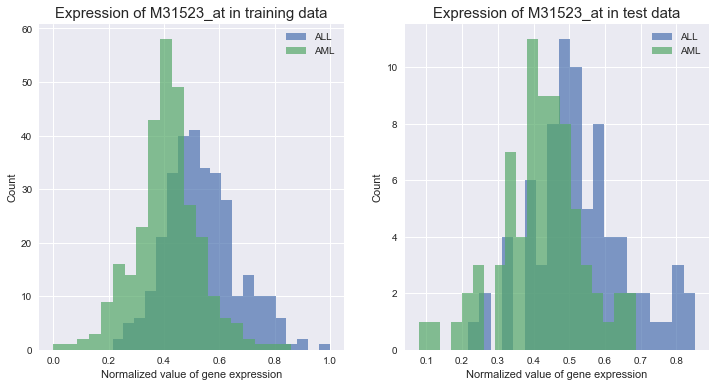

In [10]:
#your code here
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].hist(train_best_predictor[y_train==0],label='ALL',alpha=0.7,bins=20)
axes[0].hist(train_best_predictor[y_train==1],label='AML',alpha=0.7,bins=20)
axes[0].set_xlabel('Normalized value of gene expression')
axes[0].set_ylabel('Count')
axes[0].set_title('Expression of M31523_at in training data',fontsize=15)
axes[0].legend()

axes[1].hist(test_best_predictor[y_test==0],label='ALL',alpha=0.7,bins=20)
axes[1].hist(test_best_predictor[y_test==1],label='AML',alpha=0.7,bins=20)
axes[1].set_xlabel('Normalized value of gene expression')
axes[1].set_ylabel('Count')
axes[1].set_title('Expression of M31523_at in test data',fontsize=15)
axes[1].legend()

**1.4 Using your top gene from the previous part (call it  `best_predictor`), create a classification model by eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.**


0.48 is a good choice of threshold, because for normalized gene expression < 0.48, the count (density scale) of AML is greater than ALL, and vise versa for > 0.48.

In [11]:
#your code here
print('Accuracy of the eye-balling model in test set: ',accuracy_score(y_test, 1*(test_best_predictor<0.48))*100,'%')

Accuracy of the eye-balling model in test set:  66.2251655629 %


<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>


In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor that you identify as the best predictor above to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?


Create a figure with following items displayed on the same plot (use training data):
 - the predicted quantitative response from the linear regression model as a function of the best gene predictor
 - the true binary response. 


**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret the logistic regression coefficients: the 'slope' and intercept. 


Create 2 plots (one each for training and testing data) with 4 items displayed on each plot.
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



<hr>
### Solutions

**2.1** **Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML).  Is there a problem with this interpretation?**



In [12]:
# your code here
simple_linear_best_predictor = LinearRegression().fit(train_best_predictor.values.reshape(-1,1), y_train)

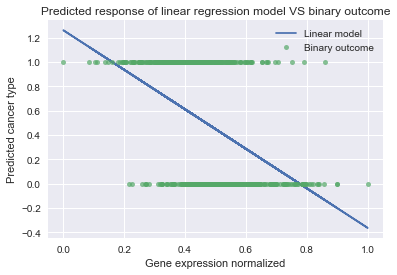

In [13]:
# your code here
y_train_pred=simple_linear_best_predictor.predict(train_best_predictor.values.reshape(-1,1))
fig, ax=plt.subplots(1,1)
ax.plot(train_best_predictor,y_train_pred,label='Linear model')
ax.plot(train_best_predictor,y_train,'o',label='Binary outcome',alpha=0.7,markersize=5)
ax.set_xlabel('Gene expression normalized')
ax.set_ylabel('Predicted cancer type')
ax.set_title('Predicted response of linear regression model VS binary outcome')
ax.legend()

*your answer here*   
The predicted response can be out of the reasonable range (0 to 1), and the binary outcome doesn't seem linear against gene repression.


**2.2** **Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.**

In [14]:
# your code here
y_train_pred_binary=1*(y_train_pred>0.5)
print('Accuracy of standard Bayes classifier on training set: ',accuracy_score(y_train, y_train_pred_binary)*100,'%')
y_test_pred=simple_linear_best_predictor.predict(test_best_predictor.values.reshape(-1,1))
y_test_pred_binary=1*(y_test_pred>0.5)
print('Accuracy of standard Bayes classifier on test set: ',accuracy_score(y_test, y_test_pred_binary)*100,'%')

Accuracy of standard Bayes classifier on training set:  70.8818635607 %
Accuracy of standard Bayes classifier on test set:  68.8741721854 %



**2.3** **Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Are the classifications substantially different?  Explain why this is the case.**

**Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

In [15]:
# your code here
logit_best_predictor=LogisticRegression(C=100000).fit(train_best_predictor.values.reshape(-1,1), y_train)
y_train_pred_logit=logit_best_predictor.predict(train_best_predictor.values.reshape(-1,1))
print('Accuracy of logistic regression model on training set: ',accuracy_score(y_train,y_train_pred_logit)*100,'%')
y_test_pred_logit=logit_best_predictor.predict(test_best_predictor.values.reshape(-1,1))
print('Accuracy of logistic regression model on test set: ',accuracy_score(y_test,y_test_pred_logit)*100,'%')

Accuracy of logistic regression model on training set:  70.7154742097 %
Accuracy of logistic regression model on test set:  70.8609271523 %


*your answer here*   
The accuracies of logistic regression model are bit higher than standard Bayes' classifier, but not significantly different. We are only using one predictor, so it may explain why our logistic model doesn't do a much better job than linear regression.


**2.4 Print and interpret the logistic regression coefficients: the 'slope' and the intercept.**

**Create 2 plots (with training and test data) with 4 items displayed on each plot.**
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$.

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.** 


In [16]:
# your code here
logit_best_predictor.coef_[0]

array([-8.75710451])

The odds of being AML for people with max M31523_at expression is $e^{-8.75710451} = 0.000157$ times of the odds of being AML for people with min M31523_at expression.

In [17]:
# your code here
logit_best_predictor.intercept_

array([ 4.07726908])

The odds of being AML for people with min M31523_at expression is $e^{4.07726908} = 58.9842$

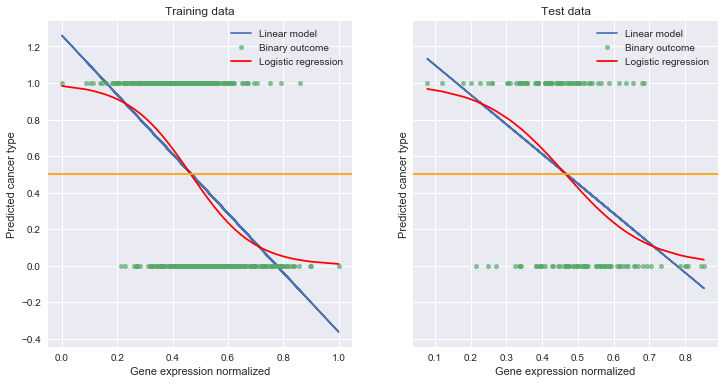

In [18]:
#chunk=np.exp(logit_best_predictor.intercept_+logit_best_predictor.coef_[0]*train_best_predictor)
#y_train_pred_logit_proba=chunk/(1+chunk)
y_train_pred_logit_proba=logit_best_predictor.predict_proba(train_best_predictor.sort_values().values.reshape(-1,1))
#chunk2=np.exp(logit_best_predictor.intercept_+logit_best_predictor.coef_[0]*test_best_predictor)
#y_test_pred_logit_proba==chunk2/(1+chunk2)
y_test_pred_logit_proba=logit_best_predictor.predict_proba(test_best_predictor.sort_values().values.reshape(-1,1))
fig, axes = plt.subplots(1,2,figsize=(12,6),sharey='row')
axes[0].plot(train_best_predictor,y_train_pred,label='Linear model')
axes[0].plot(train_best_predictor,y_train,'o',label='Binary outcome',alpha=0.7,markersize=5)
axes[0].plot(train_best_predictor.sort_values(),
             y_train_pred_logit_proba[:,1]#[train_best_predictor.sort_values().index]
             ,'r',
             label='Logistic regression')
axes[0].set_xlabel('Gene expression normalized')
axes[0].set_ylabel('Predicted cancer type')
axes[0].set_title('Training data')
axes[0].axhline(y=0.5,color='orange')
axes[0].legend()

axes[1].plot(test_best_predictor,y_test_pred,label='Linear model')
axes[1].plot(test_best_predictor,y_test,'o',label='Binary outcome',alpha=0.7,markersize=5)
axes[1].plot(test_best_predictor.sort_values(),
             y_test_pred_logit_proba[:,1]#[test_best_predictor.sort_values().index]
             ,'r',
             label='Logistic regression')
axes[1].set_xlabel('Gene expression normalized')
axes[1].set_ylabel('Predicted cancer type')
axes[1].set_title('Test data')
axes[1].axhline(y=0.5,color='orange')
axes[1].legend()

The two models have similar fitness, and none of them is significantly better than the other. Because the intersaction of the fitted models and the horizonal line y=0.5 are almost the same, the classification outcome should also be almost same.

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of training and test set? Given the results above how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole? 

**3.4** Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

<hr>
### Solutions

**3.1** **Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [19]:
# your code here
logit_allgenes=LogisticRegression(C=100000).fit(X_train_scaled.values, y_train)
y_train_pred_logit_allgenes=logit_allgenes.predict(X_train_scaled.values)
y_test_pred_logit_allgenes=logit_allgenes.predict(X_test_scaled.values)
print('Accuracy of logistic regression model on training set: ',accuracy_score(y_train,y_train_pred_logit_allgenes)*100,'%')
print('Accuracy of logistic regression model on test set: ',accuracy_score(y_test,y_test_pred_logit_allgenes)*100,'%')

Accuracy of logistic regression model on training set:  100.0 %
Accuracy of logistic regression model on test set:  77.4834437086 %


*your answer here*   
The accuracy in training data is 100%, and the accuracy in test data is also higher than the logistic regression model with single gene


**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** **To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.**  


In [20]:
coef_df=pd.DataFrame(columns=X_train.columns)
logistic_allgenes_ls=[]
train_index=X_train_scaled.index
for i in range(1,101):
    np.random.seed(i)
    bootstrap_index=np.random.choice(train_index,100)
    X_train_scaled_bootstrap=X_train_scaled.loc[bootstrap_index,]
    y_train_bootstrap=y_train[bootstrap_index]
    logistic_allgenes_i=LogisticRegression(C=100000).fit(X_train_scaled_bootstrap.values, y_train_bootstrap)
    logistic_allgenes_ls.append(logistic_allgenes_i)
    coef_df.loc[i]=logistic_allgenes_i.coef_[0]

In [21]:
from scipy.stats import ttest_1samp
ttest_1samp(train_ALL,0)

Ttest_1sampResult(statistic=array([  75.45705541,  100.48902017,   63.241968  , ...,   52.12881907,
         65.61415208,   55.90132981]), pvalue=array([  3.09275130e-200,   6.21272122e-237,   4.08212075e-178, ...,
         1.50805270e-154,   1.09262671e-182,   5.60098136e-163]))

In [22]:
print('Total number of significant coefficients: ',sum(ttest_1samp(coef_df,0)[1]<=0.05))

Total number of significant coefficients:  5427


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3.2
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Error with number of significant coefficients. Potentially because it should be a two-sided t-test. See solutions for more info.
</span></div>
<div class='alert alert-block alert-danger'><b>Grade : </b><span style = 'color:black'>-2</span></div></div>

**3.3 Open question: Comment on the classification accuracy of training and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole.**

*your answer here*  
The accuracy in training set reaches the max limit, but it is not so high comparatively in test data, which indicates that there is some kind of overfit. Such model is not capable for generalization. We can calculate the AUC of ROC to test the model better as a whole.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3.3
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Incorrect application of ROC. See solutions for more info
</span></div>
<div class='alert alert-block alert-danger'><b>Grade : </b><span style = 'color:black'>-1</span></div></div>

**3.4 Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.**

In [23]:
# your code here
logistic_cv=LogisticRegressionCV(penalty='l1',solver='liblinear').fit(X_train_scaled.values, y_train)
y_train_pred_logit_cv=logistic_cv.predict(X_train_scaled.values)
y_test_pred_logit_cv=logistic_cv.predict(X_test_scaled.values)
print('Accuracy of LASSO-logistic regression model on training set: ',accuracy_score(y_train,y_train_pred_logit_cv)*100,'%')
print('Accuracy of LASSO-logistic regression model on test set: ',accuracy_score(y_test,y_test_pred_logit_cv)*100,'%')

Accuracy of LASSO-logistic regression model on training set:  90.8485856905 %
Accuracy of LASSO-logistic regression model on test set:  86.0927152318 %


The accuracy of the logisticCV model is 91% in training data and 86% in test data.

**3.5: Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [24]:
# your code here
features_cv=X_train.columns[logistic_cv.coef_[0]>0]
features_cv

Index(['AFFX-DapX-3_at', 'D38462_at', 'D86975_at', 'J04444_at', 'L41559_at',
       'M14016_at', 'M16038_at', 'M19507_at', 'M27891_at', 'M68895_rna1_at',
       'M75126_at', 'M80254_at', 'M84526_at', 'U10868_at', 'U17280_at',
       'U19878_at', 'U28687_at', 'U46499_at', 'U50136_rna1_at', 'U77604_at',
       'X53331_at', 'X60484_at', 'X61587_at', 'X70297_at', 'X71973_at',
       'X95735_at', 'Y07604_at', 'Z11793_at', 'Z21966_at', 'U41518_at',
       'X52228_at', 'M83667_rna1_s_at', 'X85116_rna1_s_at', 'U69126_s_at'],
      dtype='object')

In [25]:
# your code here
features_cv&significant_genes

Index(['M84526_at', 'U50136_rna1_at', 'X61587_at', 'X95735_at', 'Z11793_at'], dtype='object')

*your answer here*   
Not all the 10 genes stay in the regularized model, because the LASSO regularization tend to reduce betas as much as possible to 0 and do the job of predictor selection. Those important genes not in regularized model may have colinearity with other genes and be explained by those selected by LASSO jointly.


<div class='exercise'> <b> Question 4 [25pts]: Multi Class Log Regression </b> </div>

**4.1** Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using the training dataset.  It should be easily discernable via labeling/marking in the plot which observations belong to which `cancer_type`.

**4.3** Fit the following two models using crossvalidation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundaries for each model and interpret the results. Hint: You may utilize the function `overlay_decision_boundary`. 

**4.5** Report and plot the CV scores for the two models and interpret. 


<hr>
### Solutions

**4.1 Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [26]:
#your code here
df2 = pd.read_csv('hw4_mc_enhance.csv', index_col=0)
print(df2.shape)

(750, 7130)


In [27]:
df2.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
0,-1363.276427,-1058.585495,-541.469194,74.349803,-1110.082554,-1545.661845,-2037.029616,-1255.990888,-335.480958,-938.425691,...,1565.618803,-485.680714,-170.261227,-919.114293,1675.050053,389.769289,-526.449219,-268.963924,-779.643092,0.0
1,-796.285053,-1167.103365,7.538493,83.544731,-1116.432539,-1731.392100,249.376523,-1636.960108,-149.080421,-222.783440,...,622.498054,-1275.354673,214.828233,-750.220666,-441.589276,9.841713,-671.911209,-671.911209,-644.272577,0.0
2,-679.139168,-1069.832308,-690.301829,-112.075981,-1199.319178,-1286.387935,-605.465604,-1043.041921,-728.254877,388.011238,...,162.525483,-692.534361,517.498108,-674.674103,1265.396405,-65.192805,-714.859684,3672.066149,-822.021231,0.0
3,-1164.400197,-1109.939891,-990.127218,-238.574994,-1264.607160,-1218.860503,-1255.893511,-1009.732928,-521.768585,-926.953263,...,-31.625831,-621.975549,-458.594630,-630.689198,937.767618,-264.715941,-635.046022,475.944222,-794.070116,0.0
4,-1299.653758,-1401.998536,-1077.543813,-437.344560,-1386.755697,-1726.453259,-1499.988218,-1219.084464,-994.796971,-670.342247,...,383.591216,-905.517483,-36.675640,-1116.739685,316.087213,-210.879518,-953.423549,-291.448812,-1057.945876,0.0


In [28]:
#your code here 
df2['cancer_type'].groupby(df2['cancer_type']).count()

cancer_type
0.0    250
1.0    250
2.0    250
Name: cancer_type, dtype: int64

250 instances for each type of cancer.

**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [29]:
# your code here
X2_train, X2_test, y2_train, y2_test =train_test_split(df2.loc[:, df2.columns != 'cancer_type'], 
                                                         df2.cancer_type, test_size=0.2, 
                                                         random_state = 8, 
                                                         stratify = df2.cancer_type)
X2_train=X2_train[['M31523_at','X95735_at']]
X2_test=X2_test[['M31523_at','X95735_at']]
scaler2 = MinMaxScaler()
X2_train_scaled = X2_train.copy()
X2_train_scaled[X2_train_scaled.columns] = scaler.fit_transform(X2_train_scaled[X2_train_scaled.columns])
X2_test_scaled = X2_test.copy()
X2_test_scaled[X2_test_scaled.columns] = scaler.transform(X2_test_scaled[X2_test_scaled.columns])

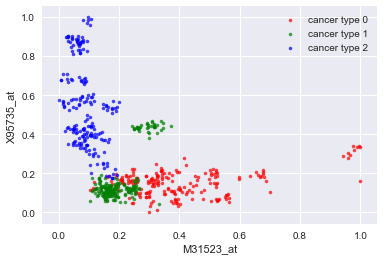

In [30]:
df2_plot=pd.concat([X2_train_scaled,y2_train],axis=1)
fig, ax=plt.subplots(1,1)
ax.scatter(df2_plot[df2_plot.cancer_type==0].M31523_at,df2_plot[df2_plot.cancer_type==0].X95735_at,
           label='cancer type 0',color='r',alpha=0.7,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==1].M31523_at,df2_plot[df2_plot.cancer_type==1].X95735_at,
           label='cancer type 1',color='g',alpha=0.7,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==2].M31523_at,df2_plot[df2_plot.cancer_type==2].X95735_at,
           label='cancer type 2',color='b',alpha=0.7,s=10)
ax.legend()
ax.set_xlabel('M31523_at')
ax.set_ylabel('X95735_at')

**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [31]:
# your code here
logistic_multi_cv=LogisticRegressionCV(penalty='l2',solver='newton-cg',multi_class='ovr').fit(X2_train_scaled.values, y2_train)

In [32]:
# your code here
X2_train_scaled_poly=X2_train_scaled.copy()
X2_train_scaled_poly['M31523_at_sq']=X2_train_scaled['M31523_at']**2
X2_train_scaled_poly['X95735_at_sq']=X2_train_scaled['X95735_at']**2
logistic_multi_cv_poly=LogisticRegressionCV(penalty='l2',solver='newton-cg',multi_class='ovr').fit(X2_train_scaled_poly.values, y2_train)

**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [33]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None,poly=False):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    if poly == True:
        X = np.c_[xx.flatten(), yy.flatten(), xx.flatten()**2,yy.flatten()**2]
    else:
        X = np.c_[xx.flatten(), yy.flatten()]
    #X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, "Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

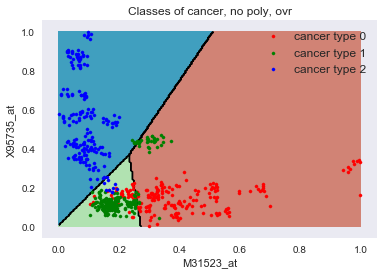

In [34]:
# Your code here
fig,ax=plt.subplots(1,1)
overlay_decision_boundary(ax, logistic_multi_cv,colors=['tomato','palegreen','deepskyblue'])
ax.scatter(df2_plot[df2_plot.cancer_type==0].M31523_at,df2_plot[df2_plot.cancer_type==0].X95735_at,
           label='cancer type 0',color='r',alpha=1,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==1].M31523_at,df2_plot[df2_plot.cancer_type==1].X95735_at,
           label='cancer type 1',color='g',alpha=1,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==2].M31523_at,df2_plot[df2_plot.cancer_type==2].X95735_at,
           label='cancer type 2',color='b',alpha=1,s=10)
ax.legend(fontsize=12)
ax.set_title('Classes of cancer, no poly, ovr')
ax.set_xlabel('M31523_at')
ax.set_ylabel('X95735_at')

In [35]:
y2_train_pred_logit_multi=logistic_multi_cv.predict(X2_train_scaled.values)
print('Accuracy of multi logistic regression model on training set: ',accuracy_score(y2_train,y2_train_pred_logit_multi)*100,'%')

Accuracy of multi logistic regression model on training set:  84.8333333333 %


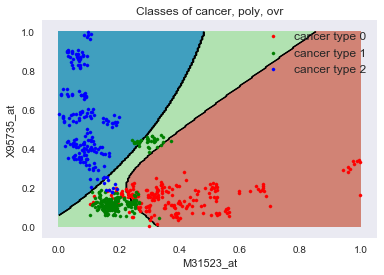

In [36]:
# your code here
fig,ax=plt.subplots(1,1)
overlay_decision_boundary(ax, logistic_multi_cv_poly,poly=True,colors=['tomato','palegreen','deepskyblue'])
ax.scatter(df2_plot[df2_plot.cancer_type==0].M31523_at,df2_plot[df2_plot.cancer_type==0].X95735_at,
           label='cancer type 0',color='r',alpha=1,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==1].M31523_at,df2_plot[df2_plot.cancer_type==1].X95735_at,
           label='cancer type 1',color='g',alpha=1,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==2].M31523_at,df2_plot[df2_plot.cancer_type==2].X95735_at,
           label='cancer type 2',color='b',alpha=1,s=10)
ax.legend(fontsize=12)
ax.set_title('Classes of cancer, poly, ovr')
ax.set_xlabel('M31523_at')
ax.set_ylabel('X95735_at')

In [37]:
y2_train_pred_logit_multi_poly=logistic_multi_cv_poly.predict(X2_train_scaled_poly.values)
print('Accuracy of multi logistic regression model with poly on training set: ',accuracy_score(y2_train,y2_train_pred_logit_multi_poly)*100,'%')

Accuracy of multi logistic regression model with poly on training set:  88.8333333333 %


The boundry of the model without poly terms is linear, while it is non-linear for the model with poly terms. The accuracy of the poly model is higher than the other model, which can result from the flexibility of the decision boundary.

From the plot above, we can see the prediction of ovr model without poly is not so good, as there are bunch of green points in red block. We can try multinomial model.

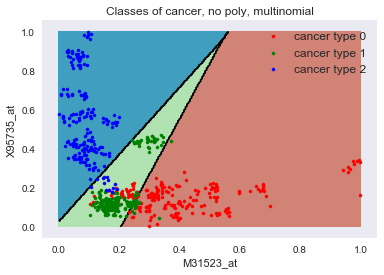

In [38]:
logistic_multi_cv_extra=LogisticRegressionCV(penalty='l2',solver='newton-cg',multi_class='multinomial').fit(X2_train_scaled.values, 
                                                                                                            y2_train)
fig,ax=plt.subplots(1,1)
overlay_decision_boundary(ax, logistic_multi_cv_extra,colors=['tomato','palegreen','deepskyblue'])
ax.scatter(df2_plot[df2_plot.cancer_type==0].M31523_at,df2_plot[df2_plot.cancer_type==0].X95735_at,
           label='cancer type 0',color='r',alpha=1,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==1].M31523_at,df2_plot[df2_plot.cancer_type==1].X95735_at,
           label='cancer type 1',color='g',alpha=1,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==2].M31523_at,df2_plot[df2_plot.cancer_type==2].X95735_at,
           label='cancer type 2',color='b',alpha=1,s=10)
ax.legend(fontsize=12)
ax.set_title('Classes of cancer, no poly, multinomial')
ax.set_xlabel('M31523_at')
ax.set_ylabel('X95735_at')

In [39]:
y2_train_pred_logit_multi_extra=logistic_multi_cv_extra.predict(X2_train_scaled.values)
print('Accuracy of multi logistic regression model on training set (multinomial): ',
      accuracy_score(y2_train,y2_train_pred_logit_multi_extra)*100,'%')

Accuracy of multi logistic regression model on training set (multinomial):  89.0 %


The accuracy improves, although we can still see blue and red points in green block.  
Try poly on multinomial.

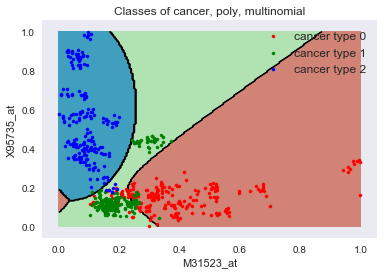

In [40]:
logistic_multi_cv_poly_extra=LogisticRegressionCV(penalty='l2',
                                                  solver='newton-cg',multi_class='multinomial').fit(X2_train_scaled_poly.values, y2_train)
fig,ax=plt.subplots(1,1)
overlay_decision_boundary(ax, logistic_multi_cv_poly_extra,poly=True,colors=['tomato','palegreen','deepskyblue'])
ax.scatter(df2_plot[df2_plot.cancer_type==0].M31523_at,df2_plot[df2_plot.cancer_type==0].X95735_at,
           label='cancer type 0',color='r',alpha=1,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==1].M31523_at,df2_plot[df2_plot.cancer_type==1].X95735_at,
           label='cancer type 1',color='g',alpha=1,s=10)
ax.scatter(df2_plot[df2_plot.cancer_type==2].M31523_at,df2_plot[df2_plot.cancer_type==2].X95735_at,
           label='cancer type 2',color='b',alpha=1,s=10)
ax.legend(fontsize=12)
ax.set_title('Classes of cancer, poly, multinomial')
ax.set_xlabel('M31523_at')
ax.set_ylabel('X95735_at')

In [41]:
y2_train_pred_logit_multi_poly_extra=logistic_multi_cv_poly_extra.predict(X2_train_scaled_poly.values)
print('Accuracy of multi logistic regression model with poly on training set (multinomial): ',
      accuracy_score(y2_train,y2_train_pred_logit_multi_poly_extra)*100,'%')

Accuracy of multi logistic regression model with poly on training set (multinomial):  91.0 %


The accuracy also improves. But the decision region for cancer type 0 (red block) has an unreasonable part on the bottom-left.

**4.5 Report and plot the CV scores for the two models and interpret.**

In [42]:
# your code here
cv_score_multi=cross_val_score(logistic_multi_cv,X2_train_scaled.values,y2_train,cv=10)
cv_score_multi_poly=cross_val_score(logistic_multi_cv_poly,X2_train_scaled_poly.values,y2_train,cv=10)
print('CV scores for model without poly: ',list(cv_score_multi))
print('CV scores for model with poly: ',list(cv_score_multi_poly))

CV scores for model without poly:  [0.84999999999999998, 0.76666666666666672, 0.83333333333333337, 0.78333333333333333, 0.84999999999999998, 0.91666666666666663, 0.83333333333333337, 0.8666666666666667, 0.84999999999999998, 0.8666666666666667]
CV scores for model with poly:  [0.90000000000000002, 0.80000000000000004, 0.83333333333333337, 0.76666666666666672, 0.8666666666666667, 0.84999999999999998, 0.8666666666666667, 0.8666666666666667, 0.81666666666666665, 0.8833333333333333]


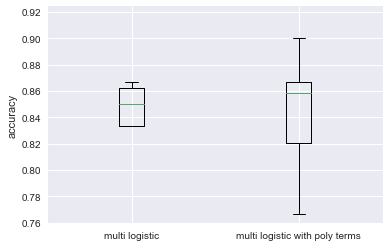

In [43]:
# your code here
fig,ax=plt.subplots(1,1)
ax.boxplot([cv_score_multi,cv_score_multi_poly])
ax.set_xticklabels(['multi logistic', 'multi logistic with poly terms'])
ax.set_ylabel('accuracy')
plt.show()
#plt.boxplot(cv_score_multi_poly)

The fluctuation of cross-validation accuracy score in model with poly terms is larger than the model without poly terms, so the model with poly terms is affected by the training data more easily.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q4.5
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Mention standard deviation. See solution for more info.
</span></div>
<div class='alert alert-block alert-danger'><b>Grade : </b><span style = 'color:black'>-2</span></div></div>

<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost.  How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the test set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.  Note that this needs to be evaluated on the patients in the test set.**
**
...
**

*your answer here* 


In [44]:
# your code here
y2_test_pred_logit_multi=logistic_multi_cv.predict(X2_test_scaled.values)
mis_predict=1-accuracy_score(y2_test,y2_test_pred_logit_multi)
print('Average cost per patient for mis-predict in $: ', 5000*mis_predict)

Average cost per patient for mis-predict in $:  700.0


**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.**

My thinking about whether to abstain a patient is that, if the probability of this patient being classified into either class is not high enough, we'll consider it "difficult to decide" and then abstain this patient. It is natural thinking because if the probability of this patient being in a certain class is dominantly high, much higher than the other two classes, we may not feel difficult or inconfident to decide this patient's class.

To balance the trade off between abstaining patients and suffering costs, we define a function to calculate the loss function, which is the overall cost per patient, for us to find optimal probability threshold.

In [45]:
# your code here
def predict_abstain(model,threshold,x,y):
    if threshold>1 or threshold<0:
        print('Threshold out of reasonalbe range')
    else:
        total_number=x.shape[0]
        predict_origin=model.predict(x)
        predict_abstain=predict_origin.copy()
        predict_abstain[model.predict_proba(x).max(axis=1)<threshold]=3 # to indicate "abstain"
        abstain_number=sum(model.predict_proba(x).max(axis=1)<threshold)
        loss_function=(5000*(total_number*(1-accuracy_score(predict_abstain,y))-abstain_number)+(1000*abstain_number))/total_number
    return loss_function

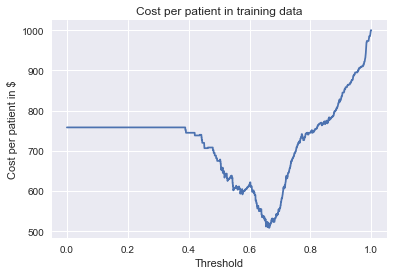

In [46]:
thresholds = np.linspace(0, 1,2000)
cost_pp_train=[]
for each in thresholds:
    loss_function=predict_abstain(logistic_multi_cv,each,X2_train_scaled.values,y2_train)
    cost_pp_train.append(loss_function)
cost_pp_train=np.array(cost_pp_train)
fig,ax=plt.subplots(1,1)
ax.plot(thresholds,cost_pp_train)
ax.set_xlabel('Threshold')
ax.set_ylabel('Cost per patient in $')
ax.set_title('Cost per patient in training data')
plt.show()

From this plot, we can see that the loss function reaches minimum at threshold=0.66, in training data. It means that with training data, we will suffer lease cost if we abstain patients whose predicted probability being in any type of cancers is less than 0.66, and keep using this model for the patients whose predicted probability being in the most likely cancer type is greater than 0.66.

Check the results with test data.

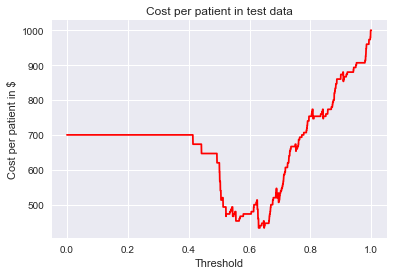

In [47]:
cost_pp_test=[]
for each in thresholds:
    loss_function=predict_abstain(logistic_multi_cv,each,X2_test_scaled.values,y2_test)
    cost_pp_test.append(loss_function)
cost_pp_test=np.array(cost_pp_test)
fig,ax=plt.subplots(1,1)
ax.plot(thresholds,cost_pp_test,'r')
ax.set_xlabel('Threshold')
ax.set_ylabel('Cost per patient in $')
ax.set_title('Cost per patient in test data')
plt.show()

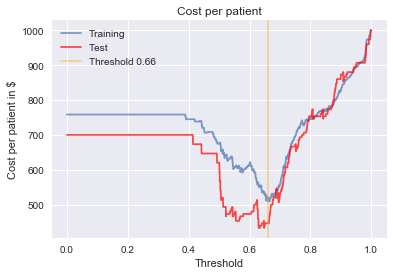

In [48]:
fig,ax=plt.subplots(1,1)
ax.plot(thresholds,cost_pp_train,label='Training',alpha=0.7)
ax.plot(thresholds,cost_pp_test,'r',label='Test',alpha=0.7)
ax.set_xlabel('Threshold')
ax.set_ylabel('Cost per patient in $')
ax.axvline(x=0.66,color='orange',label='Threshold 0.66',alpha=0.4)
ax.legend()
ax.set_title('Cost per patient')
plt.show()

The threshold we obtained is not bad in test data. So our aproach is feasible.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Checked by: Tim Pugh
</footer>